# Non-cognitive models results summary

Imports

In [1]:
from cmdstanpy import CmdStanModel
import os
import numpy as np
import pandas as pd
from datetime import datetime
import pickle
import cmdstanpy
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import halfnorm, norm
import arviz.labels as azl
import arviz as az
import math
import re
import sys

utils_path = os.path.abspath('utils')
sys.path.append(utils_path)

import summary_statistics_utils as sum
import plot_utils as sumplt
import priors

/home/anna/Work/jointErrorCMD/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read the MCMC fit object from csv files

In [4]:
model = 'sonata_cond_rt_regression'
path = '../results/models_results/pram_results/sonata'

In [5]:
fit = cmdstanpy.from_csv(path=f'{path}/{model}')
inference_data = az.from_cmdstanpy(posterior=fit)

13:01:27 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 4 had 6 divergent transitions (0.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


In [ ]:
print(fit.diagnose())

## Results summary

In [13]:
model_variables = set(fit.method_variables().keys()) | {'chain__', 'iter__', 'draw__'}
variables_to_track = [
    variable for variable in fit.draws_pd().columns
    if 'log_lik' not in variable and variable not in model_variables
]

### 1. Create and save the statistics summary

Define priors

In [14]:
priors_dict = getattr(priors, f"{model}_priors")

Calculate the results

In [15]:
try:
    summary, summary_az = sum.get_summary_with_bayes_factor(fit, inference_data, priors_dict, variables_to_track, log=True)
    summary.to_csv(f'{path}/{model}/results/{model}_summary_with_bf_log.csv')
    summary_az.to_csv(f'{path}/{model}/results/{model}_summary_with_bf_log_az.csv')
except Exception as e:
    print(e)
    print('Saving summary without bayes factors')
    summary = fit.summary()
    summary.to_csv(f'{path}/{model}/results/{model}_summary.csv')

/home/anna/Work/jointErrorCMD/python/summary_statistics_utils.py:83: RuntimeWarning: divide by zero encountered in divide
  bayes_factor_10 = prior_pdf(0) / parameter_pdf(0)
/home/anna/Work/jointErrorCMD/python/summary_statistics_utils.py:83: RuntimeWarning: overflow encountered in divide
  bayes_factor_10 = prior_pdf(0) / parameter_pdf(0)


### 2. Calculate WAIC

In [10]:
fit_df = fit.draws_pd()
model_statistics_df = sum.waic(fit_df, col='log_lik')
display(model_statistics_df)

# save the results
model_statistics_df.to_csv(f'{path}/{model}/results/{model}_model_waic_statistics.csv')

,value
lppd,-10080.188905
p_waic,312.258097
waic,20784.894005
waic_se,209.897292


## Plots

Define mapper for parameters

In [11]:
titles_mapper = {
    'participants_cond': r"$\theta_{(c)j}$",   
    'participants_ern': r"$\theta_{(EN)j}$",
    'participants_crn': r"$\theta_{(CN)j}$",
    'participants_ne': r"$\theta_{(e)j}$",
    'participants_ne_acc': r"$\theta_{(er)j}$",
    'participants_mu': r"$\mu_{j}$",

    'cond_sd': r"$\sigma_{(c)}$",
    'ne_sd': r"$\sigma_{(e)}$",
    'ne_acc_sd': r"$\sigma_{(er)}$",
    'mu_sd': r"$\sigma_{(\mu)}$",

    'cond': r"$\mu_{\theta_{(c)}}$",
    'ne': r"$\mu_{\theta_{(e)}}$",
    'ne_acc': r"$\mu_{\theta_{(er)}}$",
    'acc': r"$\theta_{(r)}$",
    'ne_cond': r"$\theta_{(ec)}$",
    'acc_cond': r"$\theta_{(rc)}$",
    'ne_acc_cond': r"$\theta_{(erc)}$",

    'ern': r"$\theta_{(EN)}$",
    'crn': r"$\theta_{(CN)}$",

    'mu': r"$\mu$",
    'sigma': r"$\sigma$",
} if model == 'sonata_cond_acc_regression' else 
{
    'participants_cond': r"$\theta_{(c)j}$",   
    'participants_ern': r"$\theta_{(EN)j}$",
    'participants_crn': r"$\theta_{(CN)j}$",
    'participants_ne': r"$\theta_{(e)j}$",
    'participants_ne_acc': r"$\theta_{(er)j}$",
    'participants_mu': r"$\mu_{j}$",

    'cond_sd': r"$\sigma_{(c)}$",
    'ne_sd': r"$\sigma_{(e)}$",
    'ne_acc_sd': r"$\sigma_{(er)}$",
    'mu_sd': r"$\sigma_{(\mu)}$",

    'cond': r"$\mu_{\theta_{(c)}}$",
    'ne': r"$\mu_{\theta_{(e)}}$",
    'ne_acc': r"$\mu_{\theta_{(er)}}$",
    'acc': r"$\theta_{(r)}$",
    'ne_cond': r"$\theta_{(ec)}$",
    'acc_cond': r"$\theta_{(rc)}$",
    'ne_acc_cond': r"$\theta_{(erc)}$",

    'ern': r"$\theta_{(EN)}$",
    'crn': r"$\theta_{(CN)}$",

    'mu': r"$\mu$",
}

### 1. Draw Traces

In [ ]:
var_names_participants = [
    'participants_cond', 
    'participants_ne', 
    'participants_ne_acc', 
]

var_names_main = [
    'participants_ern', 
    'participants_crn', 
]

# extract fixed effects without variability effects
var_names_population = [variable for variable in variables_to_track if (('participant' not in variable) and ('sd' not in variable) and ('prop' not in variable) and ('sigma' not in variable))]

# extract variability effects
base_variables_to_track_sd = [variable for variable in variables_to_track if (('participant' not in variable) and ('prop' not in variable) and ('sd' in variable) or ('sigma' in variable))]

for index, variables in enumerate([var_names_participants, var_names_main, var_names_population, base_variables_to_track_sd]):
    sumplt.plot_traces(
        inference_data,
        variables,
        save=index+1,
        mapper=titles_mapper,
        path=path,
        model=model
    )

### 2. Draw fixed effects distributions

/home/anna/Work/jointErrorCMD/python/plot_utils.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/home/anna/Work/jointErrorCMD/python/plot_utils.py:118: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


<Figure size 5750x2500 with 0 Axes>

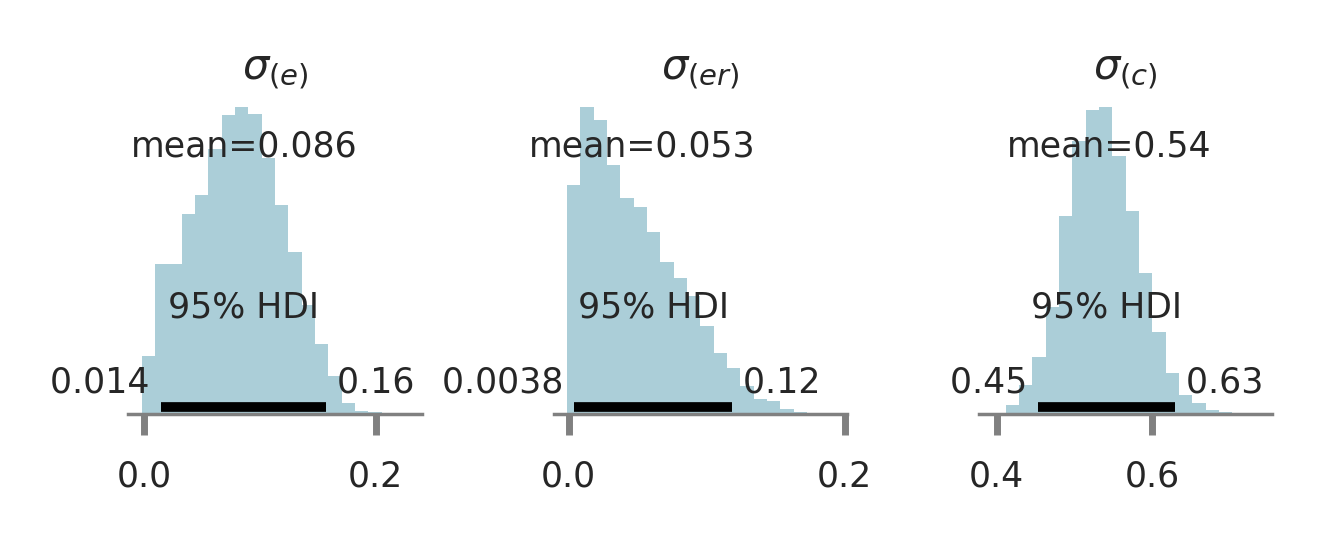

<Figure size 5750x2500 with 0 Axes>

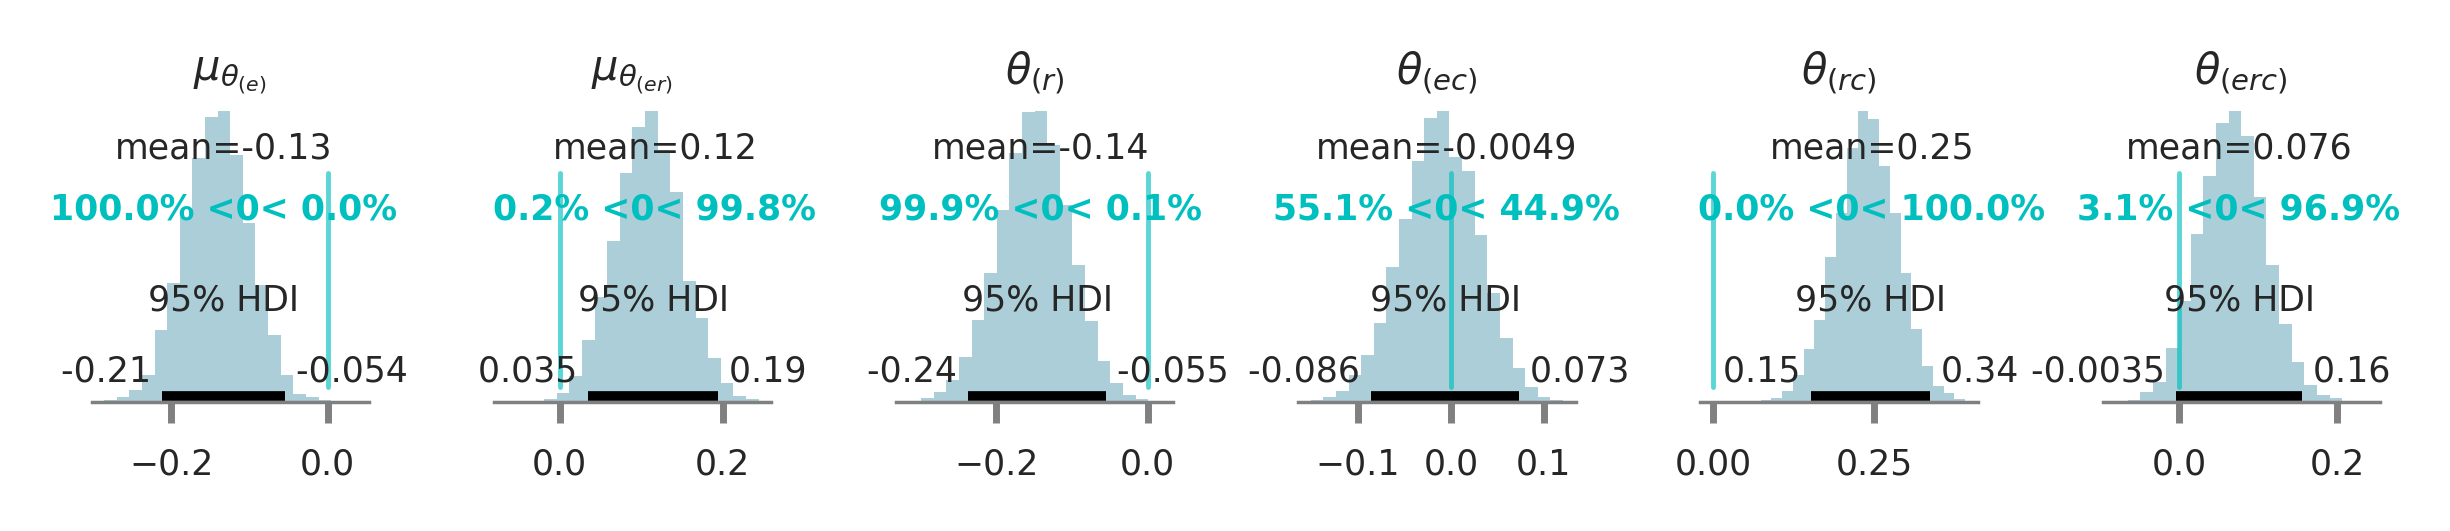

<Figure size 5750x2500 with 0 Axes>

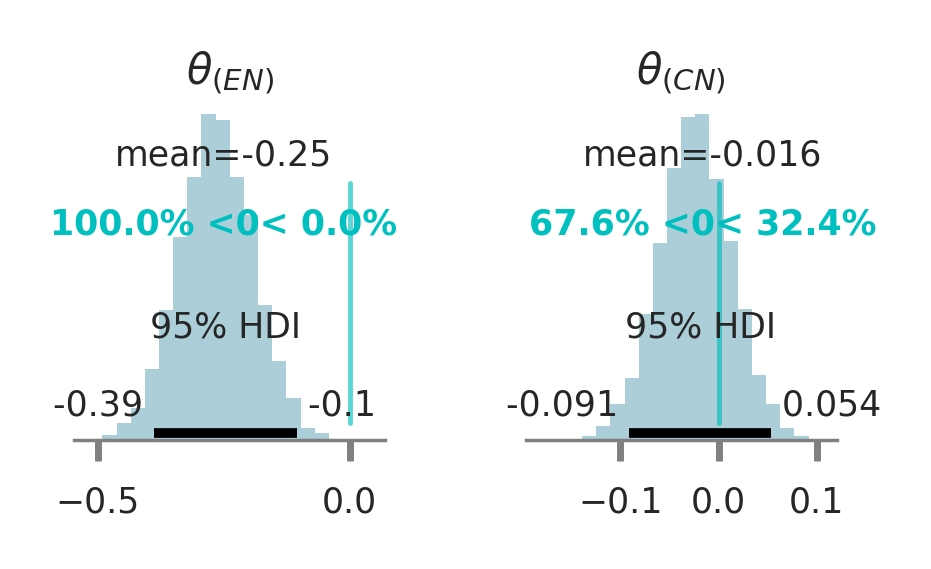

In [13]:
variability_parameters = [
    'ne_sd', 
    'ne_acc_sd', 
    'cond_sd',
    # 'sigma'
]

fixed_effects = [
    'ne', 
    'ne_acc',
    'acc',
    'ne_cond', 
    'acc_cond', 
    'ne_acc_cond', 
]
main_effects = ['ern', 'crn']

variables_list = [
    variability_parameters,
    fixed_effects,
    main_effects, 
]
# set reference values 
refrence_values = [None, 0, 0]

for index, (variables, ref) in enumerate(zip(variables_list, refrence_values)):
    sumplt.plot_posteriors(
        inference_data, 
        variables,
        ref,
        save=index+1,
        dpi=500,
        mapper=titles_mapper,
        path=path,
        model=model,
    )

### 3. Bayes factors distributions
TODO

Read model statistics

In [15]:
summary_df = pd.read_csv(f"{path}/{model}/results/{model}_summary_with_bf_log.csv").set_index('Unnamed: 0')

In [16]:
# Extract Bayes Factors for the effects
summary_copy = summary_df.copy()
summary_copy['parameter_name'] = summary_copy.index.str.extract(r'([a-zA-Z_]+(?:_[a-zA-Z]+)*)', expand=False)
# summary_copy.groupby(['parameter_name']).agg(['min', 'max', 'median']).to_csv(f'{path}/{model}/results/{model}_parameters_aggegation.csv')
summary_copy_random_effects = summary_copy[(~summary_copy['Bayes_factor'].isna()) & (summary_copy['parameter_name'].str.contains('participants', case=False, na=False))]
summary_copy_random_effects.reset_index(inplace=True)
summary_copy_random_effects = summary_copy_random_effects.sort_values(by=['parameter_name', 'Bayes_factor'])

In [17]:
### 

### 4. Effects distributions

In [14]:
def get_random_effects_draws_with_bf(fit_df, summary_df, variables_to_track):
    # Include chain and iteration variables
    variables_to_track += ['chain__', 'iter__']
    
    # Melt the fit_df to long format
    melted_fit_df = pd.melt(fit_df[variables_to_track], 
                            id_vars=['chain__', 'iter__'], 
                            var_name='parameter', 
                            value_name='value')
    
    # Extract parameter names
    melted_fit_df['parameter_name'] = melted_fit_df['parameter'].str.extract(r'([a-zA-Z_]+(?:_[a-zA-Z]+)*)', expand=False)
    
    # Filter for random effects
    random_effects = melted_fit_df[
        melted_fit_df['parameter_name'].str.contains('participants', case=False, na=False) & 
        melted_fit_df['value'].notna()
    ].reset_index(drop=True)
    
    # Calculate mean values by parameter and merge back to random_effects
    mean_values = random_effects.groupby('parameter')['value'].mean().rename('value_mean').reset_index()
    random_effects = random_effects.merge(mean_values, on='parameter')
    
    # Sort by parameter name and mean values
    random_effects_sorted = random_effects.sort_values(by=['parameter_name', 'value_mean'])
    
    # Prepare summary_df for Bayes Factor extraction
    summary_df = summary_df.copy()
    summary_df['parameter_name'] = summary_df.index.str.extract(r'([a-zA-Z_]+(?:_[a-zA-Z]+)*)', expand=False)
    
    # Filter for participant-related parameters in summary_df
    summary_random_effects = summary_df[
        summary_df['parameter_name'].str.contains('participants', case=False, na=False)
    ]
    
    # Add Bayes Factor if available
    if 'Bayes_factor' in summary_random_effects.columns:
        random_effects_sorted['bayes_factor'] = random_effects_sorted['parameter'].map(summary_random_effects['Bayes_factor'])
    
    return random_effects_sorted

Prepare data

In [15]:
summary_df = pd.read_csv(f"{path}/{model}/results/{model}_summary_with_bf_log.csv").set_index('Unnamed: 0')

fit_df = fit.draws_pd()
random_effects_melted = get_random_effects_draws_with_bf(fit_df, summary_df, variables_to_track)

Plot random effects with BF

/home/anna/Work/jointErrorCMD/venv/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 4370.08x1033.46 with 0 Axes>

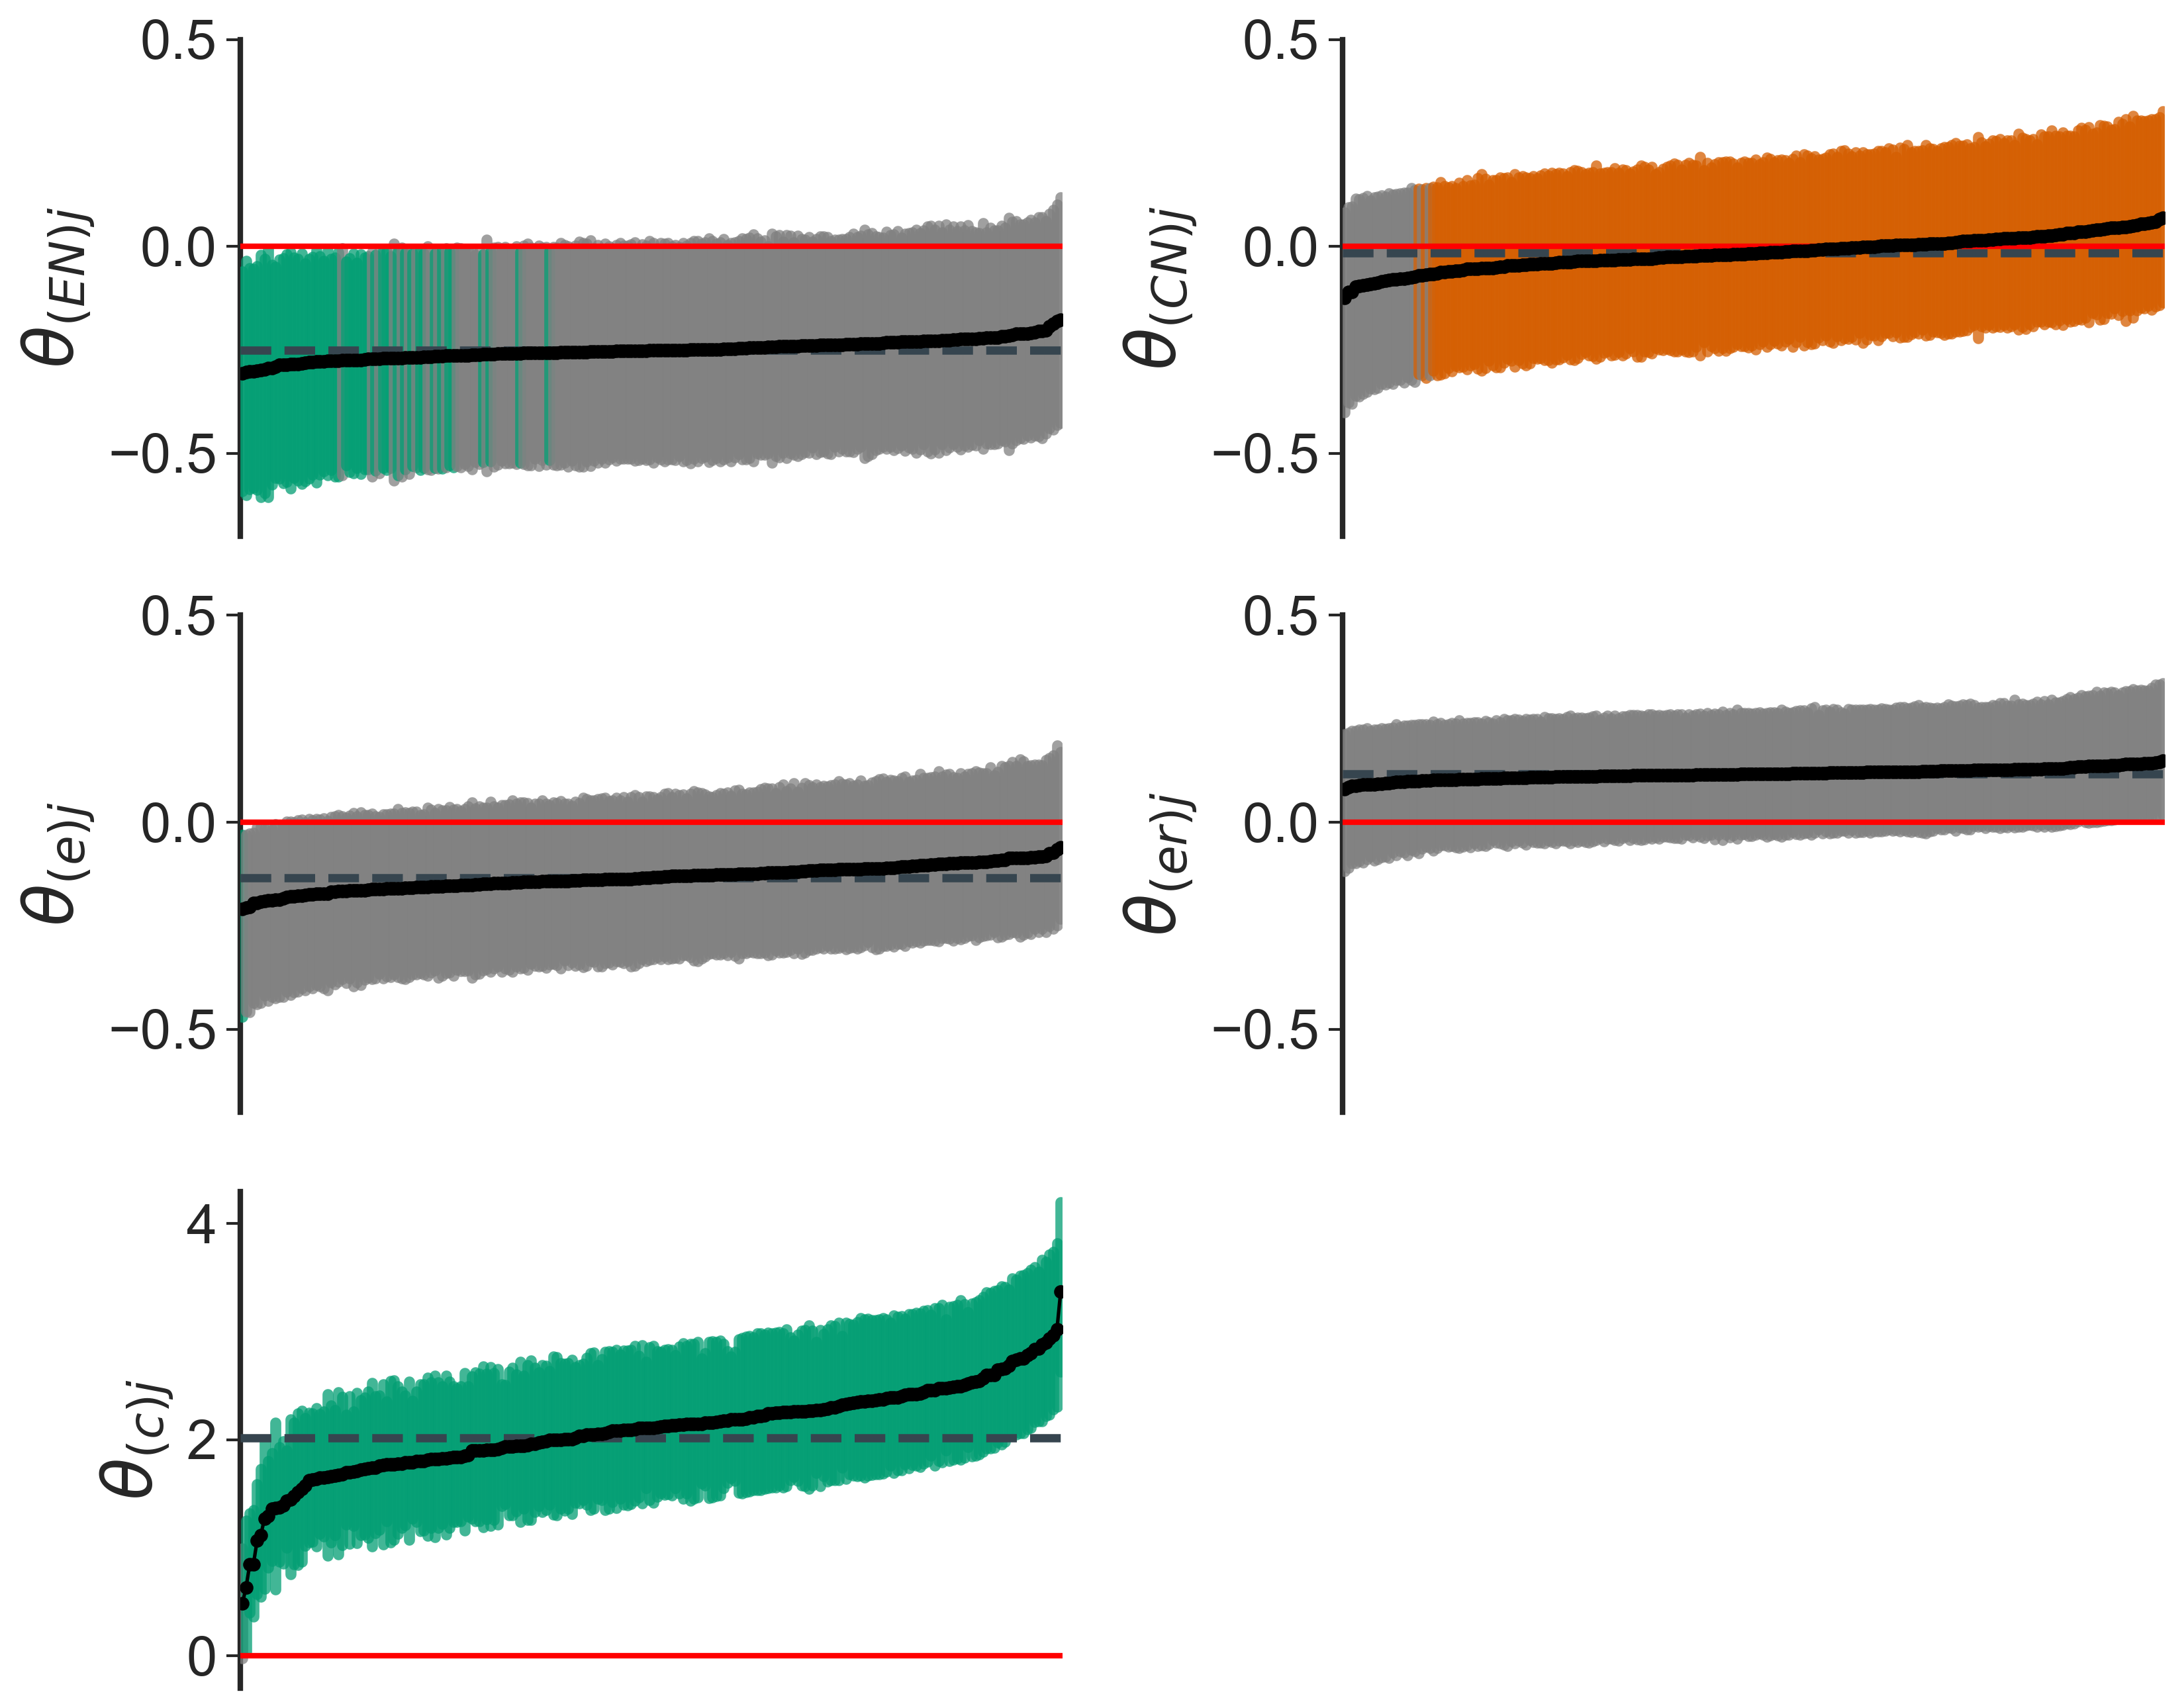

In [18]:
effects_titles_mapper = {
    'participants_cond': r"$\theta_{(c)j}$",   
    'participants_ern': r"$\theta_{(EN)j}$",
    'participants_crn': r"$\theta_{(CN)j}$",
    'participants_ne': r"$\theta_{(e)j}$",
    'participants_ne_acc': r"$\theta_{(er)j}$",
}

parameter_name_order = [
    'participants_ern',
    'participants_crn',
    'participants_ne',
    'participants_ne_acc',
    'participants_cond'
]

y_lims = [(-.7, 0.5), (-.7, 0.5),(-.7, 0.5),(-.7, 0.5), (-.3, 4.3)]
sumplt.plot_random_effects_distributions(
    inference_data = inference_data, 
    summary_df=summary_df, 
    df=random_effects_melted, 
    effects_titles_mapper=effects_titles_mapper, 
    parameter_name_order=parameter_name_order, 
    save='random_effects_distributions',
    path=path, 
    model=model, 
    n_cols=2, 
    aspect=1.9, 
    sharey=False, 
    dpi=300,
    y_lim=y_lims
)

## Create fixed effects summary for paper

- fixed effects

In [16]:
model = 'sonata_cond_rt_regression'
path = '../../plgrid_results/pram_results/sonata'

results_df = pd.read_csv(f'{path}/{model}/results/{model}_summary_with_bf_log_az.csv').rename(columns={'Unnamed: 0': 'parameter'})

if model == 'sonata_cond_rt_regression':
        for col in ['mean', 'sd', 'hdi_2.5%', 'hdi_97.5%']:
            if col in results_df.columns:
                results_df.loc[:, col] *= 1000 

In [17]:
row_order = ['mu', 'cond', 'ne', 'acc', 'ne_acc', 'ne_cond', 'acc_cond', 'ne_acc_cond', 'mu_sd', 'cond_sd', 'ne_sd', 'ne_acc_sd', 'sigma', 'ern', 'crn']
parameter_type = 'all'

fixed_effects_summary = sum.get_fixed_effects_summary_az(results_df, row_order,  type=parameter_type, decimal_notation_limit=(200, 0.01))
fixed_effects_summary.to_csv(f'{path}/{model}/results/{model}_{parameter_type}_paper_summary_az.csv')

/home/anna/Work/jointErrorCMD/python/summary_statistics_utils.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['3.02e+02' '-29.05' '-2.96' '0.27' '34.90' '9.83' '2.39' '2.79' '-10.90'
 '1.52' '1.62' '-0.72' '58.82' '-3.23' '-2.69']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  fixed_effects.loc[:, ['mean', 'sd', 'Bayes_factor']] = fixed_effects[['mean', 'sd', 'Bayes_factor']].map(format_func)
/home/anna/Work/jointErrorCMD/python/summary_statistics_utils.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['2.42' '0.85' '0.43' '0.44' '1.70' '0.58' '0.56' '0.48' '0.54' '0.40'
 '0.53' '0.40' '0.19' '0.77' '0.42']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  fixed_effects.loc[:, ['mean', 'sd', 'Bayes_factor']] = fixed_effects[['mean', 'sd', 'Bayes_f